In [1]:
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, InceptionV3
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

def load_data(data_dir, img_size=(256, 256)):
    images = []
    labels = []
    label_names = sorted(os.listdir(data_dir))
    label_to_index = {label_name: idx for idx, label_name in enumerate(label_names)}

    for label_name in label_names:
        label_dir = os.path.join(data_dir, label_name)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if img_file.lower().endswith(('.png', '.tif', '.jpg', '.jpeg')):
                    img = load_img(img_path, target_size=img_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(label_to_index[label_name])
                else:
                    print(f"Ignoring non-image file: {img_path}")

    if not images or not labels:
        raise ValueError(f"No images or labels found in {data_dir}. Check your dataset path and structure.")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_names

# Define the path to your training and testing dataset
train_dataset_path = '/Users/jakaria/Documents/ACC/Project/UCMerced_LandUse1/Images/Train'
test_dataset_path = '/Users/jakaria/Documents/ACC/Project/UCMerced_LandUse1/Images/Test'

# Load training data
try:
    X_train, y_train, train_label_names = load_data(train_dataset_path)
except ValueError as e:
    print(str(e))

# Load testing data
try:
    X_test, y_test, test_label_names = load_data(test_dataset_path)
except ValueError as e:
    print(str(e))

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Ensure labels are consistent
all_label_names = sorted(set(train_label_names) | set(test_label_names))
label_to_index = {label_name: idx for idx, label_name in enumerate(all_label_names)}
num_classes = len(all_label_names)

# Re-encode labels with consistent indexing across train and test sets
y_train = np.array([label_to_index[train_label_names[i]] for i in y_train])
y_test = np.array([label_to_index[test_label_names[i]] for i in y_test])

# Convert labels to categorical format based on the correct number of classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Check if the dimensions are correct
if len(X_train) != len(y_train):
    raise ValueError("Mismatch between number of training images and labels.")
if len(X_test) != len(y_test):
    raise ValueError("Mismatch between number of testing images and labels.")

# Print number of loaded samples for debugging
print(f"Number of training images loaded: {len(X_train)}")
print(f"Number of training labels loaded: {len(y_train)}")
print(f"Number of testing images loaded: {len(X_test)}")
print(f"Number of testing labels loaded: {len(y_test)}")

# Print unique labels for debugging
print(f"Unique labels: {all_label_names}")
print(f"Number of classes: {num_classes}")

# Print shapes after conversion
print(f"y_train shape after conversion: {y_train.shape}")
print(f"y_test shape after conversion: {y_test.shape}")

Number of training images loaded: 1660
Number of training labels loaded: 1660
Number of testing images loaded: 462
Number of testing labels loaded: 462
Unique labels: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Number of classes: 21
y_train shape after conversion: (1660, 21)
y_test shape after conversion: (462, 21)


In [2]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator
val_datagen = ImageDataGenerator()
batch_size = 32

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(batch_size).repeat()

2024-08-05 20:31:46.162538: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-05 20:31:46.162568: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-05 20:31:46.162574: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-05 20:31:46.162595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-05 20:31:46.162610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Unfreeze the convolutional base
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Training the model
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size
epochs = 10

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

# Evaluate the model
vgg16_evaluation_results = model.evaluate(X_test, y_test)

# Unpack the evaluation results
test_loss, test_accuracy, test_precision, test_recall = vgg16_evaluation_results

print(f'Test accuracy: {test_accuracy*100:.2f}%')
print(f'Test precision: {test_precision*100:.2f}%')
print(f'Test recall: {test_recall*100:.2f}%')

Epoch 1/10


2024-08-05 20:31:48.324440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


51/51 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3610 - loss: 2.2551 - precision: 0.6594 - recall: 0.1622 - val_accuracy: 0.6920 - val_loss: 1.2062 - val_precision: 0.9535 - val_recall: 0.3661
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8227 - loss: 0.7614 - precision: 0.9459 - recall: 0.5962 - val_accuracy: 0.7744 - val_loss: 0.9951 - val_precision: 0.9945 - val_recall: 0.4209
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9220 - loss: 0.4883 - precision: 0.9806 - recall: 0.7516 - val_accuracy: 0.8000 - val_loss: 0.8547 - val_precision: 0.9547 - val_recall: 0.5395
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9563 - loss: 0.3419 - precision: 0.9870 - recall: 0.8485 - val_accuracy: 0.8465 - val_loss: 0.7213 - val_precision: 0.9603 - val_recall: 0.6186
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9862 - loss: 0.2326 - precision: 0.9944 - recall: 0.9373 - val_accuracy: 0.8419 - val_loss: 0.7222 - val_precision:

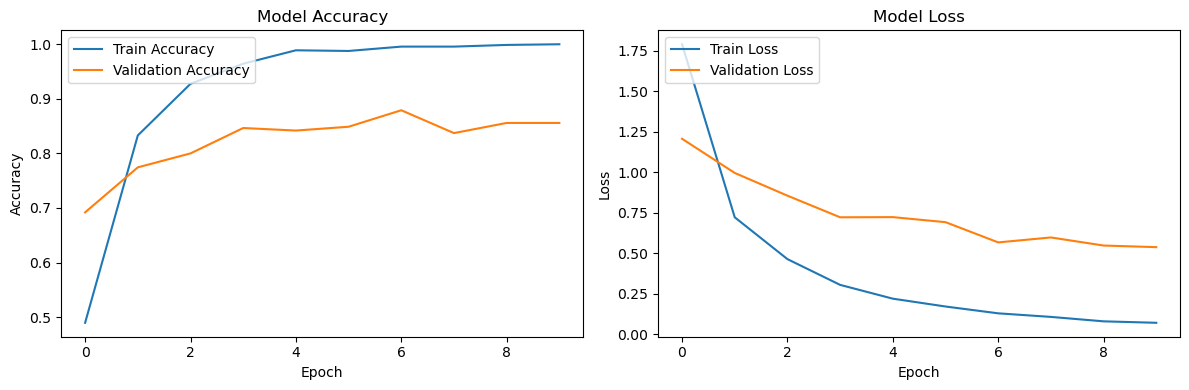

In [4]:
# Function to plot training and validation accuracy and loss values:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

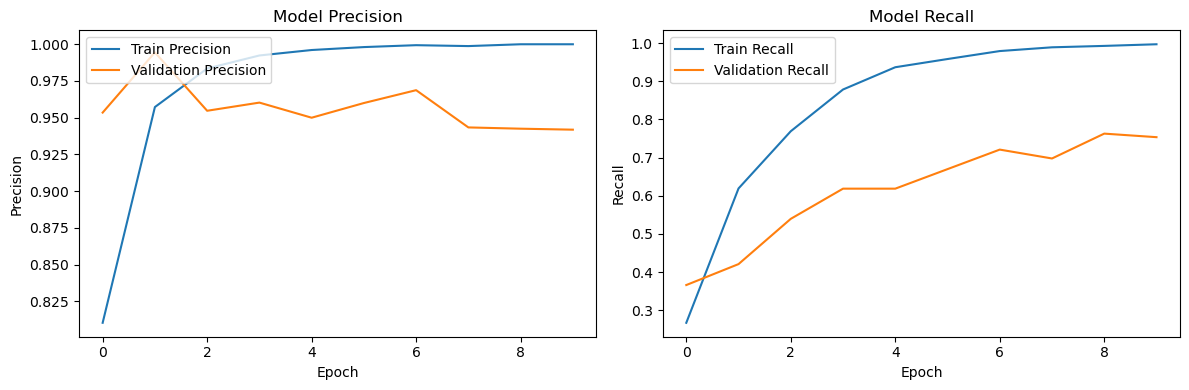

In [5]:
def plot_training_metrics(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation precision values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Plot training & validation recall values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot the training metrics  
plot_training_metrics(history)

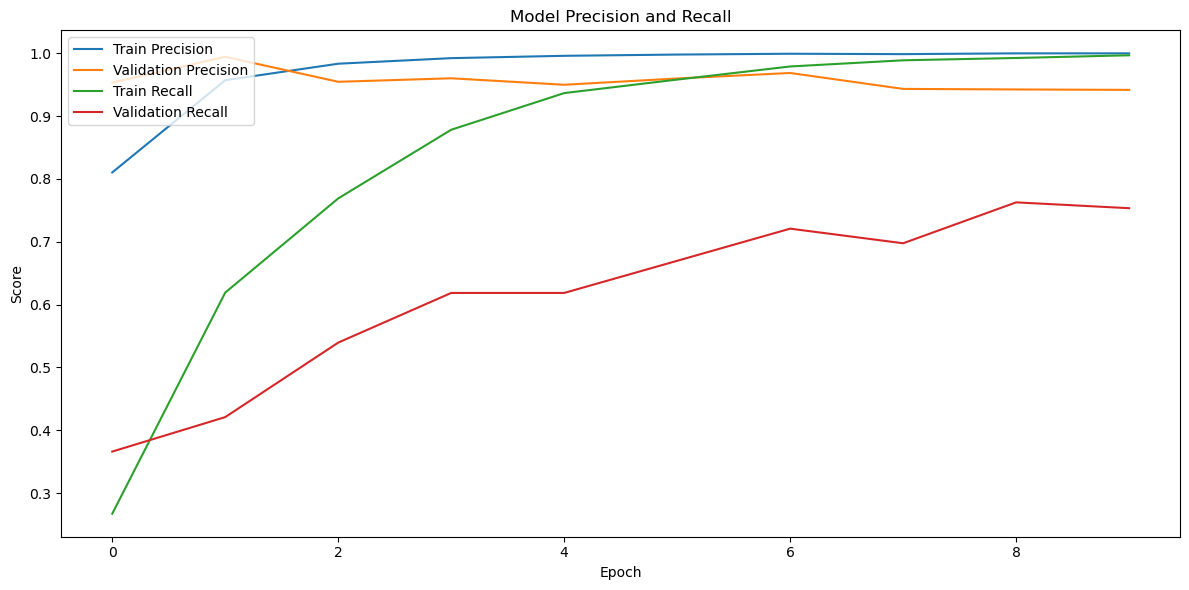

In [6]:
def plot_combined_precision_recall(history):
    plt.figure(figsize=(12, 6))
    
    # Plot combined precision and recall values
    plt.subplot(1, 1, 1)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Model Precision and Recall')
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot combined precision and recall
plot_combined_precision_recall(history)


15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


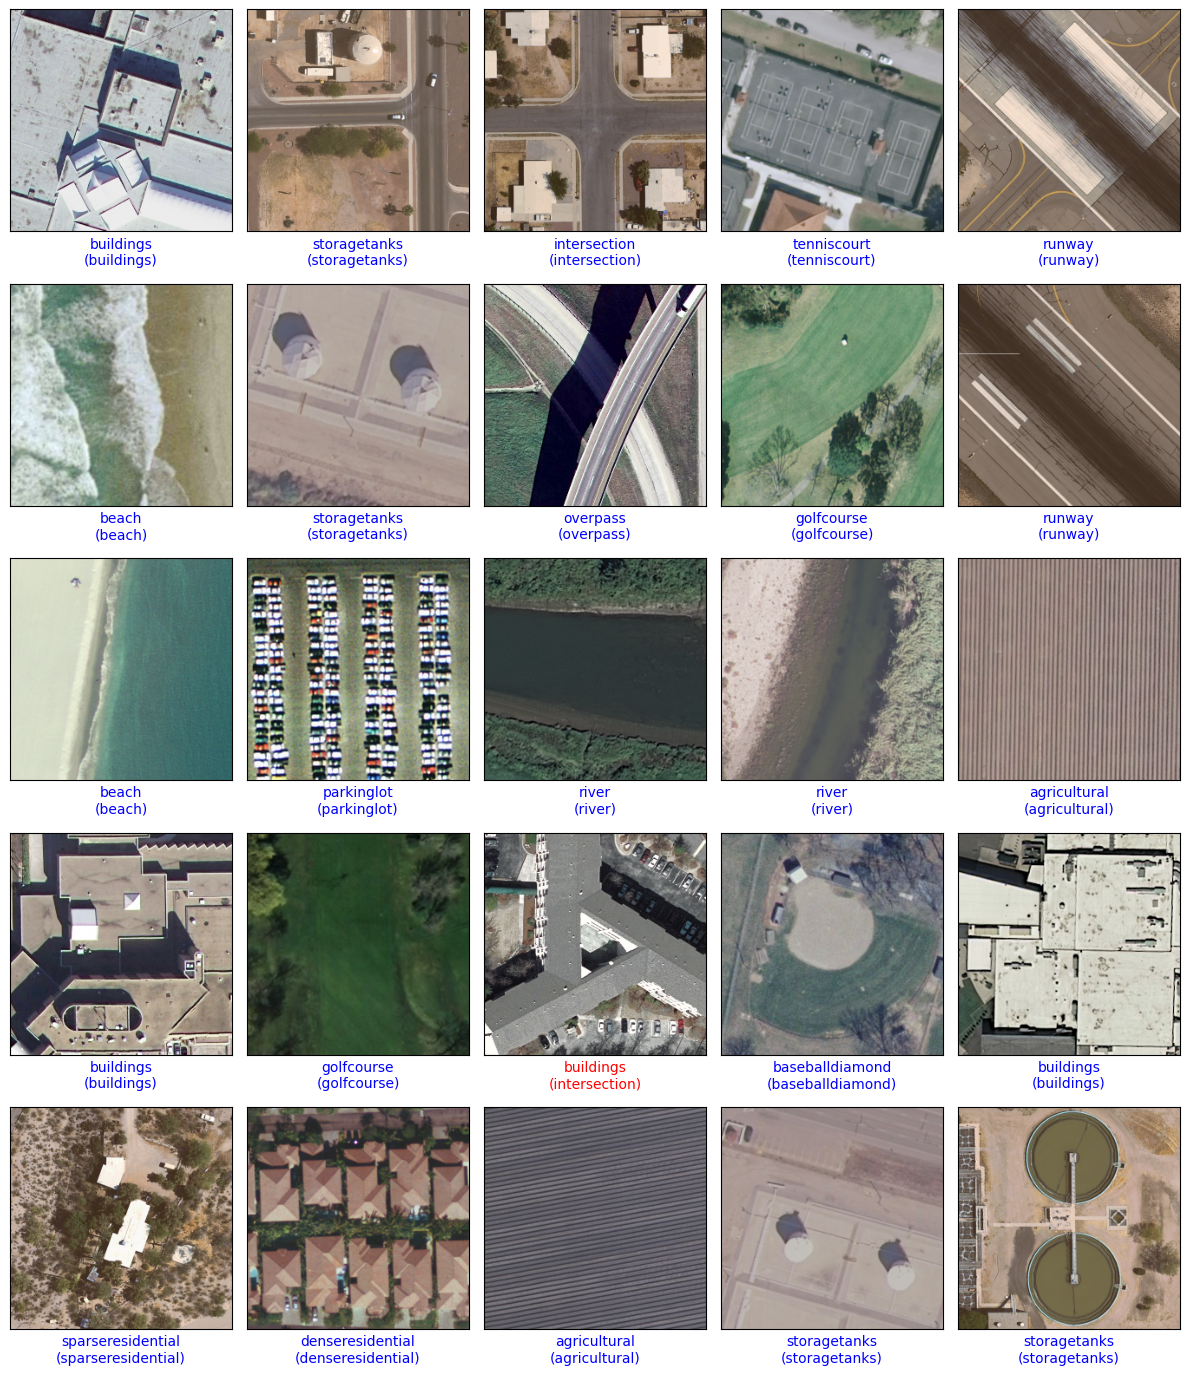

In [7]:
# Function to plot images along with predicted and true labels
def plot_images(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(12, 14))
    indices = np.random.permutation(len(images))[:25]  # Shuffle indices and take the first 25
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[idx])
        true_label = class_names[np.argmax(true_labels[idx])]
        pred_label = class_names[np.argmax(pred_labels[idx])]
        color = 'blue' if true_label == pred_label else 'red'
        plt.xlabel(f'{true_label}\n({pred_label})', color=color)
    plt.tight_layout()
    plt.show()

# Get predictions for the test set
predictions = model.predict(X_test)

# Ensure the class names match the order of the labels
class_names = [all_label_names[i] for i in range(num_classes)]

# Plot images with predictions
plot_images(X_test, y_test, predictions, class_names)


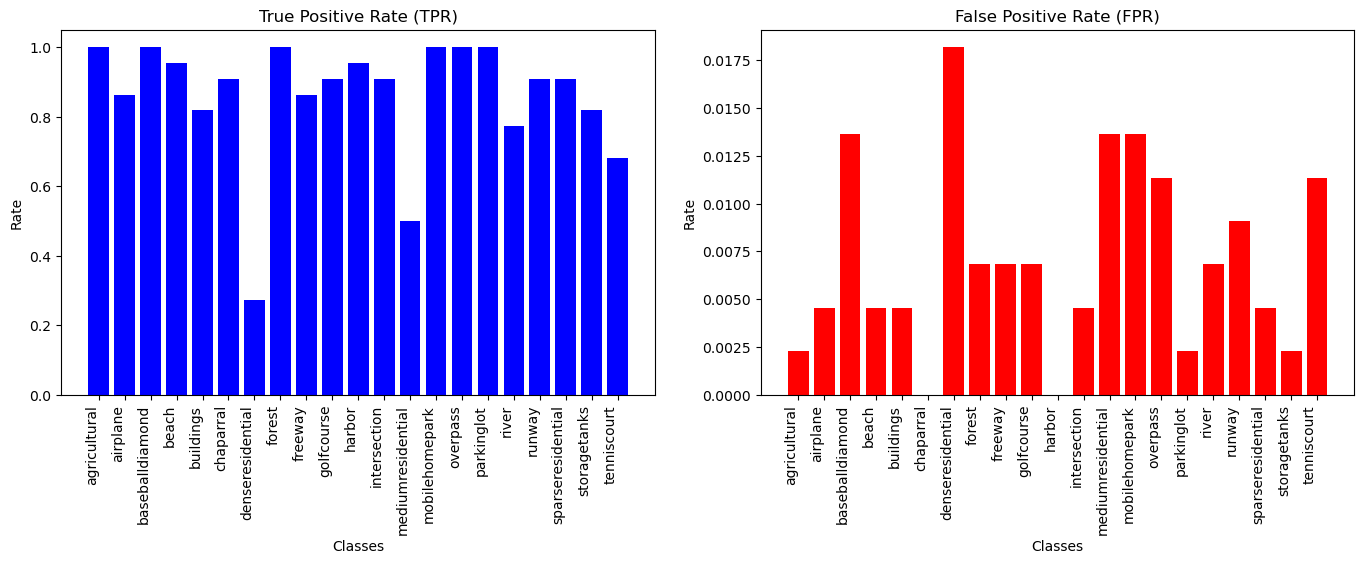

In [8]:
def plot_tpr_fpr(y_test, predictions, class_names):
    # Flatten the y_test and predictions for metric calculations
    y_test_flat = np.argmax(y_test, axis=1)
    predictions_flat = np.argmax(predictions, axis=1)

    # Calculate True Positive Rate (TPR) for each class
    TPR = recall_score(y_test_flat, predictions_flat, average=None)
    
    # Calculate False Positive Rate (FPR) for each class
    unique_labels = np.unique(y_test_flat)
    FPR = []

    for i in range(len(unique_labels)):
        FP = np.sum((predictions_flat == i) & (y_test_flat != i))
        TN = np.sum((predictions_flat != i) & (y_test_flat != i))
        FPR.append(FP / (FP + TN))

    # Plot TPR and FPR
    x = np.arange(len(class_names))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.bar(x, TPR, color='blue')
    plt.xticks(x, class_names, rotation=90, ha='right')  # Rotate labels to 90 degrees and align to the right
    plt.xlabel('Classes')
    plt.ylabel('Rate')
    plt.title('True Positive Rate (TPR)')

    plt.subplot(1, 2, 2)
    plt.bar(x, FPR, color='red')
    plt.xticks(x, class_names, rotation=90, ha='right')  # Rotate labels to 90 degrees and align to the right
    plt.xlabel('Classes')
    plt.ylabel('Rate')
    plt.title('False Positive Rate (FPR)')

    plt.tight_layout(pad=2)  # Add more padding to ensure labels do not overlap
    plt.show()

plot_tpr_fpr(y_test, predictions, class_names)

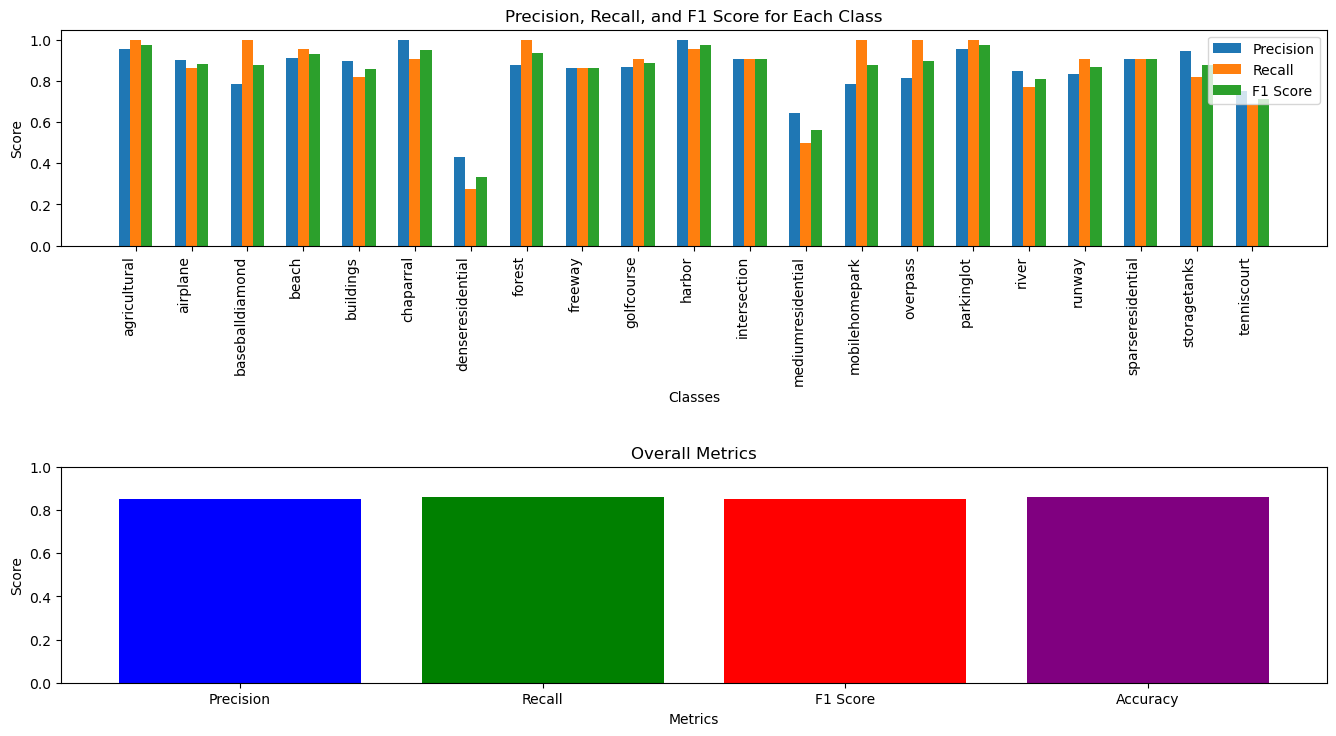

Classification Report:
                    precision    recall  f1-score   support

     agricultural       0.96      1.00      0.98        22
         airplane       0.90      0.86      0.88        22
  baseballdiamond       0.79      1.00      0.88        22
            beach       0.91      0.95      0.93        22
        buildings       0.90      0.82      0.86        22
        chaparral       1.00      0.91      0.95        22
 denseresidential       0.43      0.27      0.33        22
           forest       0.88      1.00      0.94        22
          freeway       0.86      0.86      0.86        22
       golfcourse       0.87      0.91      0.89        22
           harbor       1.00      0.95      0.98        22
     intersection       0.91      0.91      0.91        22
mediumresidential       0.65      0.50      0.56        22
   mobilehomepark       0.79      1.00      0.88        22
         overpass       0.81      1.00      0.90        22
       parkinglot       0.96   

In [9]:
def plot_classification_report(y_test, predictions, class_names):
    # Flatten the y_test and predictions for metric calculations
    y_test_flat = np.argmax(y_test, axis=1)
    predictions_flat = np.argmax(predictions, axis=1)

    # Generate the classification report
    class_report = classification_report(y_test_flat, predictions_flat, target_names=class_names, output_dict=True, zero_division=0)

    # Check if all classes are present in the classification report
    for class_name in class_names:
        if class_name not in class_report:
            class_report[class_name] = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}

    # Extracting metrics for each class
    precision = [class_report[class_name]['precision'] for class_name in class_names]
    recall = [class_report[class_name]['recall'] for class_name in class_names]
    f1 = [class_report[class_name]['f1-score'] for class_name in class_names]

    # Creating a dataframe for the classification report
    report_df = pd.DataFrame(class_report).transpose()

    # Ensure the dataframe is indexed by the class names
    report_df = report_df.reindex(class_names)

    # Exclude the support column and the last row with averages
    report_df = report_df.drop(columns=["support"], errors='ignore')
    report_df = report_df.loc[class_names]

    # Plotting metrics for each class
    x = np.arange(len(class_names))

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    bar_width = 0.2
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision')
    plt.bar(x, recall, width=bar_width, label='Recall')
    plt.bar(x + bar_width, f1, width=bar_width, label='F1 Score')
    plt.xticks(x, class_names, rotation=90, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score for Each Class')
    plt.legend()

    # Plotting overall metrics
    plt.subplot(2, 1, 2)
    metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
    overall_scores = [precision_score(y_test_flat, predictions_flat, average='macro', zero_division=0),
                      recall_score(y_test_flat, predictions_flat, average='macro', zero_division=0),
                      f1_score(y_test_flat, predictions_flat, average='macro', zero_division=0),
                      accuracy_score(y_test_flat, predictions_flat)]
    plt.bar(metrics, overall_scores, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Overall Metrics')

    plt.tight_layout(pad=3)
    plt.show()

    # Printing the classification report as a string
    class_report_str = classification_report(y_test_flat, predictions_flat, target_names=class_names, zero_division=0)
    print("Classification Report:\n", class_report_str)

plot_classification_report(y_test, predictions, class_names)

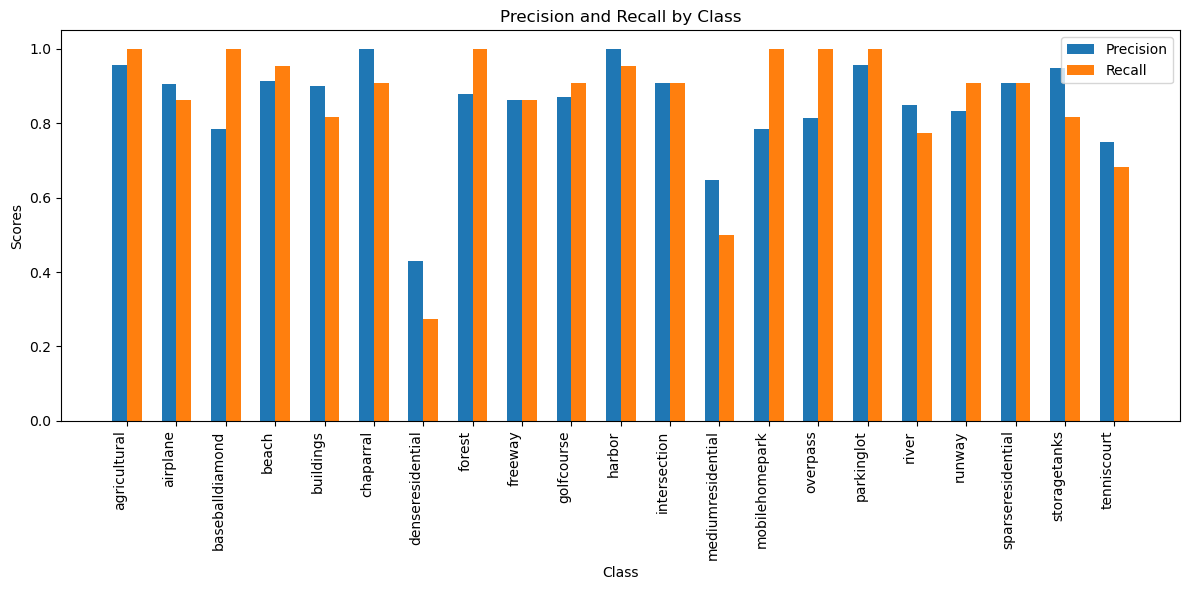

In [10]:
def plot_PR(y_test, predictions, class_names):
    # Flatten the y_test and predictions for metric calculations
    y_test_flat = np.argmax(y_test, axis=1)
    predictions_flat = np.argmax(predictions, axis=1)

    # Generate the classification report
    class_report = classification_report(y_test_flat, predictions_flat, target_names=class_names, output_dict=True, zero_division=0)

    # Convert the classification report to a DataFrame
    report_df = pd.DataFrame(class_report).transpose()

    # Exclude 'accuracy', 'macro avg', and 'weighted avg' from the class-specific metrics
    report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0, errors='ignore')

    # Extract precision, recall
    precision = report_df['precision']
    recall = report_df['recall']
    

    # Plot the precision and recall
    x = np.arange(len(class_names))
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, precision, width, label='Precision')
    rects2 = ax.bar(x + width/2, recall, width, label='Recall')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Class')
    ax.set_ylabel('Scores')
    ax.set_title('Precision and Recall by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=90, ha='right')
    ax.legend()

    fig.tight_layout()

    plt.show()

# Ensure the class names match the order of the labels
class_names = [all_label_names[i] for i in range(num_classes)]

# Plot precision and recall from the classification report
plot_PR(y_test, predictions, class_names)


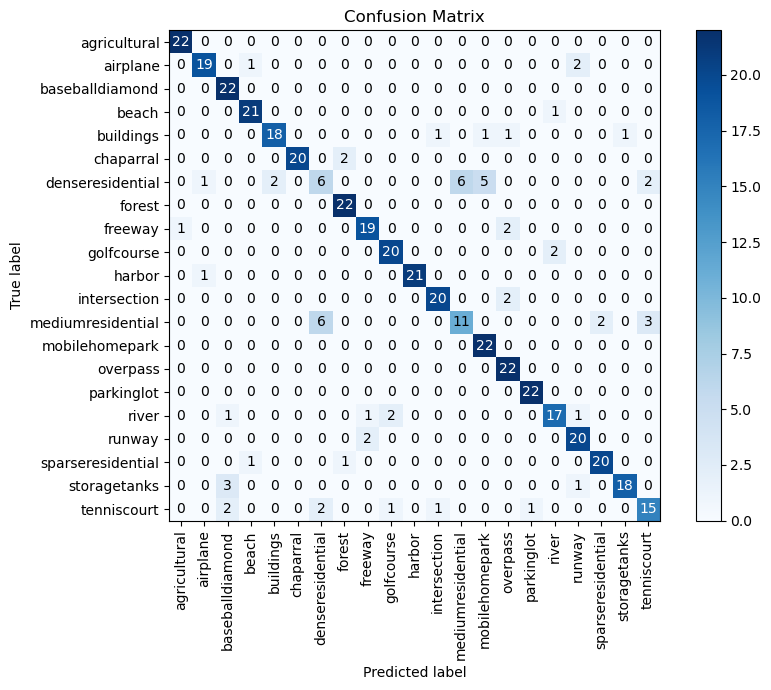

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, predictions, class_names):
    # Flatten the y_test and predictions for metric calculations
    y_test_flat = np.argmax(y_test, axis=1)
    predictions_flat = np.argmax(predictions, axis=1)
    # Calculate metrics
    cm = confusion_matrix(y_test_flat, predictions_flat)
    plt.figure(figsize=(9, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(y_test, predictions, class_names)

In [12]:
# Load pre-trained InceptionV3 model + higher level layers
IV3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Unfreeze the convolutional base
IV3_base_model.trainable = False

# Create a new model on top
IV3_model = Sequential([
    IV3_base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

IV3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])


In [13]:
# Training the model
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size
epochs = 10  

IV3_history = IV3_model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_dataset,
    validation_steps=validation_steps,
)

# Evaluate the model
IV3_evaluation_results = IV3_model.evaluate(X_test, y_test)

# Unpack the evaluation results
IV3_test_loss, IV3_test_accuracy, IV3_test_precision, IV3_test_recall = IV3_evaluation_results

print(f'Test accuracy: {IV3_test_accuracy*100:.2f}%')
print(f'Test precision: {IV3_test_precision*100:.2f}%')
print(f'Test recall: {IV3_test_recall*100:.2f}%')

Epoch 1/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 56s 917ms/step - accuracy: 0.5020 - loss: 1.8776 - precision: 0.7721 - recall: 0.3225 - val_accuracy: 0.8013 - val_loss: 0.6154 - val_precision: 0.8941 - val_recall: 0.7723
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 45s 811ms/step - accuracy: 0.9366 - loss: 0.3581 - precision: 0.9754 - recall: 0.8403 - val_accuracy: 0.8698 - val_loss: 0.4627 - val_precision: 0.9471 - val_recall: 0.7907
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 773ms/step - accuracy: 0.9884 - loss: 0.1408 - precision: 0.9969 - recall: 0.9643 - val_accuracy: 0.8651 - val_loss: 0.5062 - val_precision: 0.9516 - val_recall: 0.7767
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 778ms/step - accuracy: 0.9976 - loss: 0.0813 - precision: 0.9976 - recall: 0.9923 - val_accuracy: 0.8767 - val_loss: 0.4713 - val_precision: 0.9517 - val_recall: 0.7791
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 777ms/step - accuracy: 0.9981 - loss: 0.0652 - precision: 0.9987 - recall: 0.9966 - val_accuracy: 0.8884 - val_los

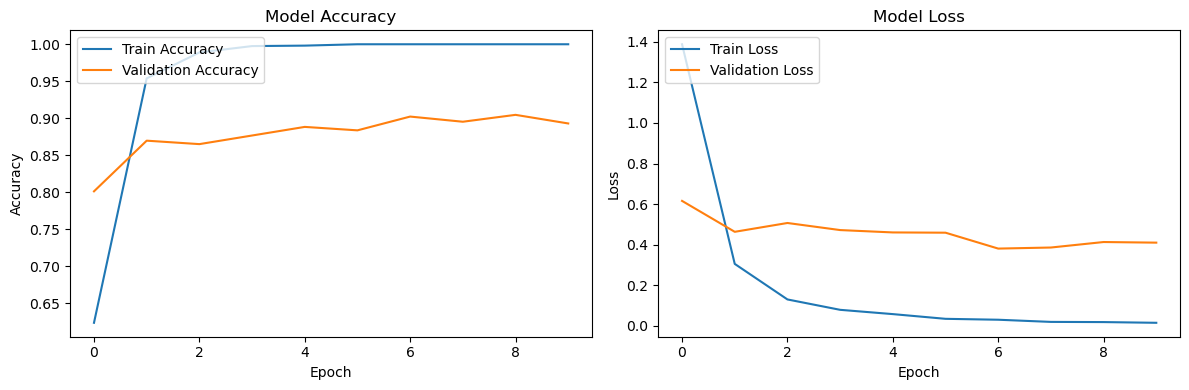

In [14]:
plot_training_history(IV3_history)

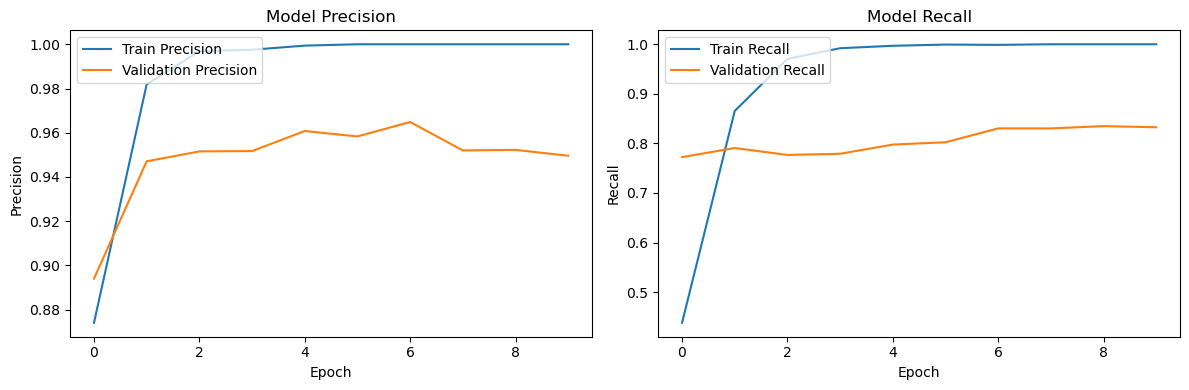

In [15]:
# Plot the training metrics
plot_training_metrics(IV3_history)

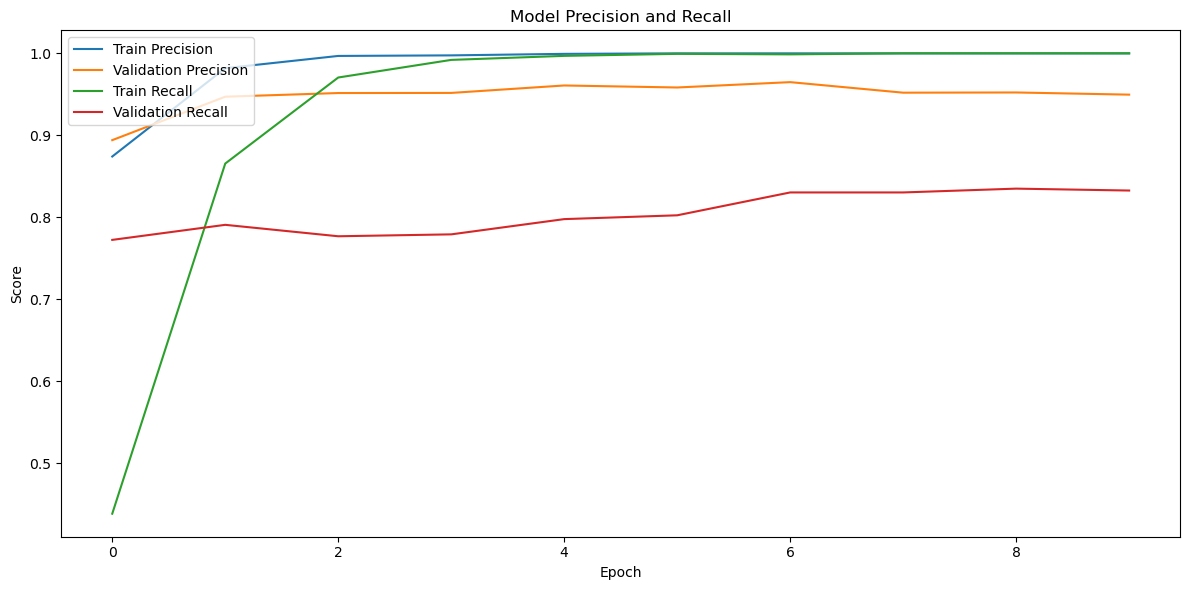

In [16]:
# Plot combined precision and recall
plot_combined_precision_recall(IV3_history)

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


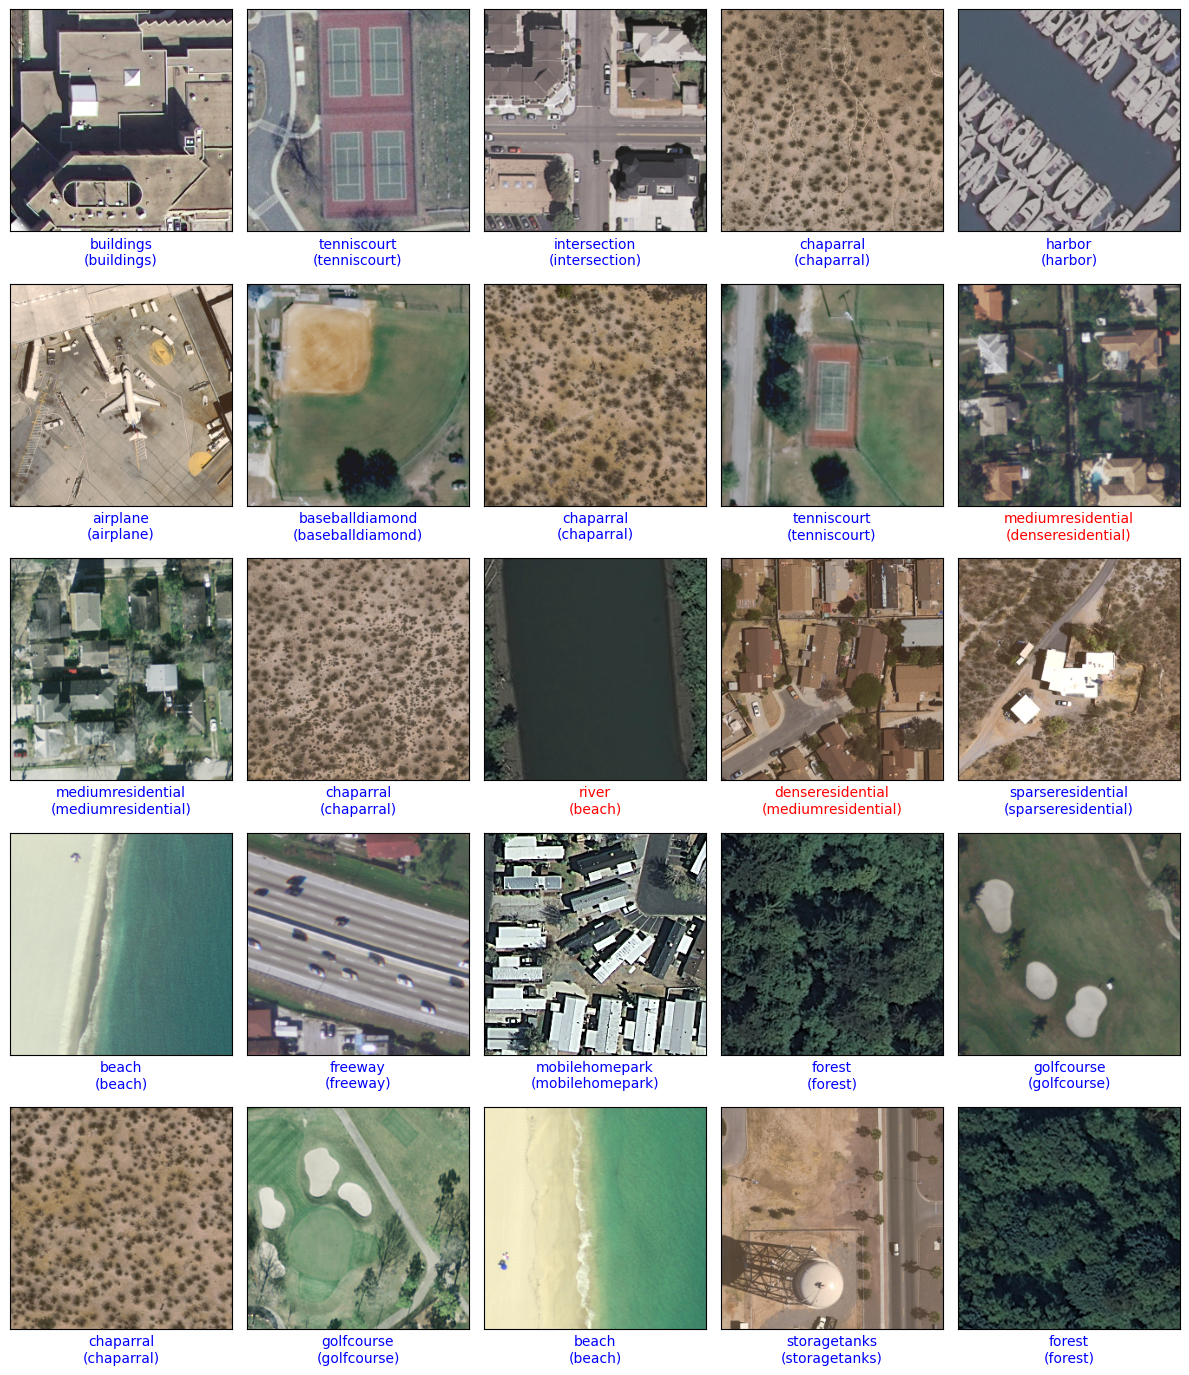

In [17]:
# Get predictions for the test set
IV3_predictions = IV3_model.predict(X_test)

# Plot images with predictions
plot_images(X_test, y_test, IV3_predictions, class_names)

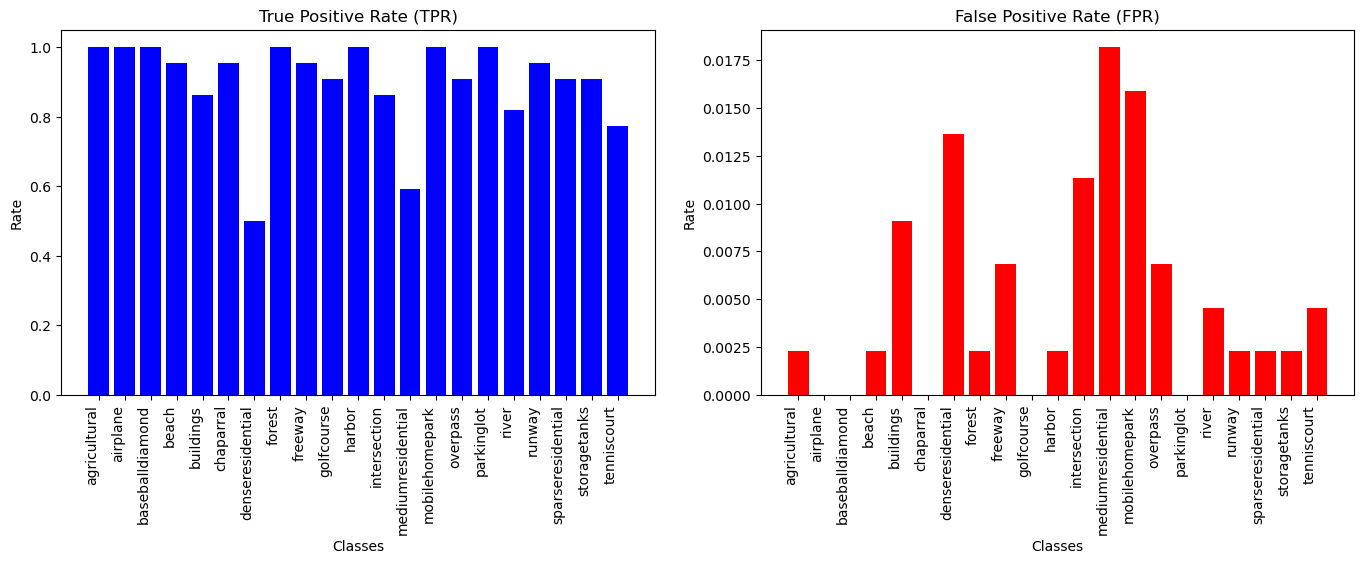

In [18]:
plot_tpr_fpr(y_test, IV3_predictions, class_names)

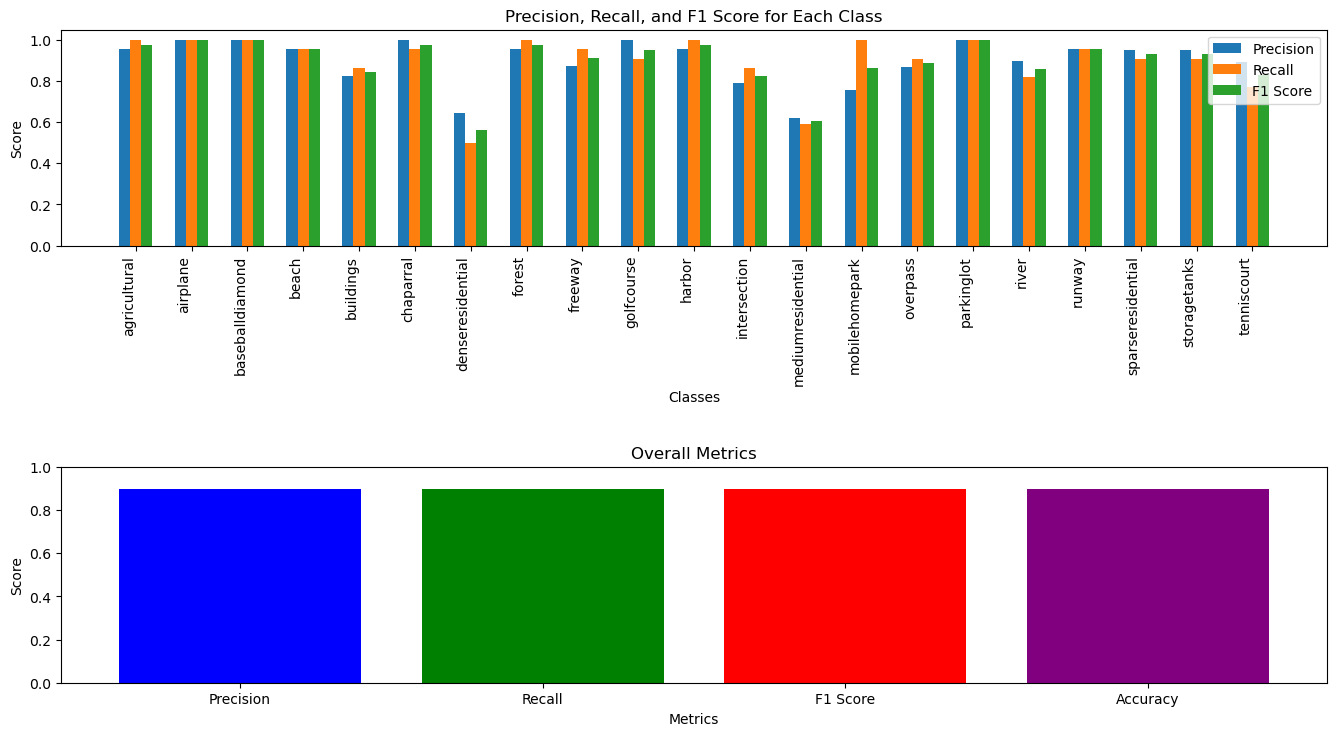

Classification Report:
                    precision    recall  f1-score   support

     agricultural       0.96      1.00      0.98        22
         airplane       1.00      1.00      1.00        22
  baseballdiamond       1.00      1.00      1.00        22
            beach       0.95      0.95      0.95        22
        buildings       0.83      0.86      0.84        22
        chaparral       1.00      0.95      0.98        22
 denseresidential       0.65      0.50      0.56        22
           forest       0.96      1.00      0.98        22
          freeway       0.88      0.95      0.91        22
       golfcourse       1.00      0.91      0.95        22
           harbor       0.96      1.00      0.98        22
     intersection       0.79      0.86      0.83        22
mediumresidential       0.62      0.59      0.60        22
   mobilehomepark       0.76      1.00      0.86        22
         overpass       0.87      0.91      0.89        22
       parkinglot       1.00   

In [19]:
plot_classification_report(y_test, IV3_predictions, class_names)

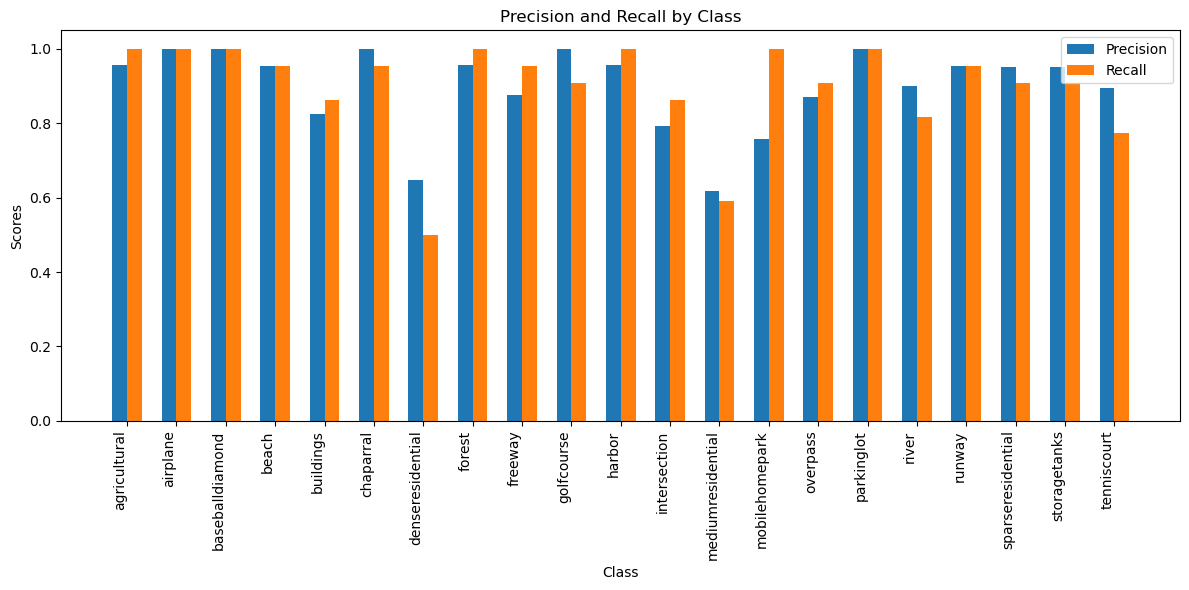

In [20]:
# Plot precision and recall from the classification report
plot_PR(y_test, IV3_predictions, class_names)


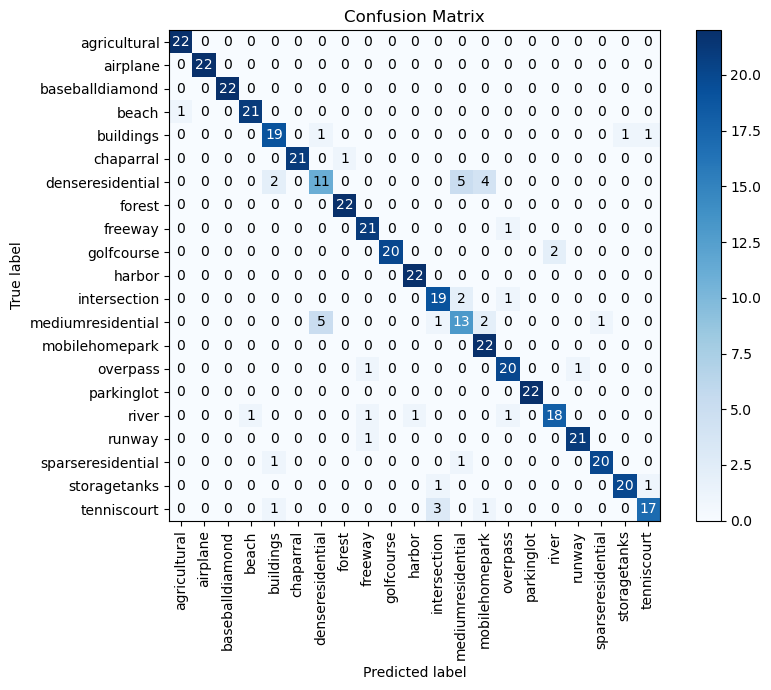

In [21]:
plot_confusion_matrix(y_test,IV3_predictions, class_names)

In [22]:
import pickle

def save_model(model, model_name):
    model_json = model.to_json()
    model_weights = model.get_weights()

    # Save each weight array separately
    for i, weight in enumerate(model_weights):
        np.save(f'{model_name}_weight_{i}.npy', weight)

    weights_files = [f'{model_name}_weight_{i}.npy' for i in range(len(model_weights))]
    with open(f'{model_name}_model.pkl', 'wb') as f:
        pickle.dump((model_json, weights_files), f)

# Save InceptionV3 model
save_model(IV3_model, 'inceptionv3')

# Save VGG16 model
save_model(model,'vgg16')

In [26]:
import pickle

# Save the model architecture to JSON
model_json = model.to_json()
with open("vgg16_model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("vgg16_weights.weights.h5")


In [27]:
# Create a dictionary to hold the model paths
model_paths = {
    "model_json": "vgg16_model.json",
    "model_weights": "vgg16_weights.keras"
}

# Save the dictionary using pickle
with open('vgg16_model_paths.pkl', 'wb') as f:
    pickle.dump(model_paths, f)
